Homework 4: LLM evaluation
=====

The third homework zooms in on evaluating LLMs, specifically, on the following skills: using log probabilities of string under a trained LM to evaluate it, coming up with items to test particular aspets of LLMs, and comparing LLM measures to measures of human performance.

### Logistics

* submission deadline: July 13th th 23:59 German time via Moodle
  * please upload a **SINGLE .IPYNB FILE named Surname_FirstName_HW4.ipynb** containing your solutions of the homework. Make sure that your **plots** for the last exercise are either rendered in the notebook or submitted together with it in a zip file. 
* please solve and submit the homework **individually**! 
* if you use Colab, to speed up the execution of the code on Colab, you can use the available GPU (if Colab resources allow). For that, before executing your code, navigate to Runtime > Change runtime type > GPU > Save.

## Exercise 1: Understanding grammatical capabilities of LLMs (10 points)

In this task, we look at [BLiMP](https://aclanthology.org/2020.tacl-1.25/), the benchmark of linguistic minimal pairs. This is a well-known benchmark for evaluating linguistic capabilities of language models. It consists of 67 individual datasets, each containing 1,000 minimal pairs -- that is, pairs of minimally different sentences that contrast in grammatical acceptability and isolate specific phenomenon in syntax, morphology, or semantics. The authors suggest to use the benchmark to evaluate LMs by observing whether they assign a higher probability to the acceptable sentence in each minimal pair.

> Your task is to evaluate an open-source model, [Pythia-160m](https://huggingface.co/EleutherAI/pythia-160m), on this benchmark by completing the code below. Based on your evaluation results, please answer the following questions.
> Please use the following test suites to answer them: anaphor_gender_agreement, determiner_noun_agreement_with_adjective_1, animate_subject_passive, complex_NP_island, npi_present_1, superlative_quantifiers_1, existential_there_object_raising, principle_A_case_1.
> 
> The entire benchmark can be found [here](https://huggingface.co/datasets/nyu-mll/blimp).
> 
> 1. Plot the accuracy of the model on the different grammatical phenomena, represented in different test suites.
> 2. Calculate the average accuracies and the confidence intervals in the different fields: syntax, morphology, syntax-semantics, semantics. Is the performance the same across the different fields? Which field is the most difficult one?

The performance is different across the different fields. syntax_semantics is the most difficult one.
> 3. What is the easiest grammatical phenomenon, what is the most difficult gramamtical phenomenon (as captured by the single test suites) for the model?

npi_present_1 is the easiest grammatical phenomenon.
principle_A_case_1 is the most difficult gramamtical phenomenon.

In [82]:
from datasets import load_dataset
import torch
from minicons import scorer 

In [83]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [91]:
# iterate over the test suites 

#### YOUR CODE HERE ####
test_suites = {
    'anaphor_gender_agreement': 'morphology',
    'determiner_noun_agreement_with_adjective_1': 'morphology',
    'animate_subject_passive': 'syntax',
    'complex_NP_island': 'syntax',
    'npi_present_1': 'semantics',
    'superlative_quantifiers_1': 'semantics',
    'existential_there_object_raising': 'syntax_semantics',
    'principle_A_case_1': 'syntax_semantics'
}

# Load datasets
#### YOUR TEST SUITE HERE ####
datasets = {name: load_dataset("nyu-mll/blimp", name) for name in test_suites.keys()}

 
# inspect the dataset
datasets['anaphor_gender_agreement']["train"][0]

{'sentence_good': "Katherine can't help herself.",
 'sentence_bad': "Katherine can't help himself.",
 'field': 'morphology',
 'linguistics_term': 'anaphor_agreement',
 'UID': 'anaphor_gender_agreement',
 'simple_LM_method': True,
 'one_prefix_method': True,
 'two_prefix_method': False,
 'lexically_identical': False,
 'pair_id': 0}

In [94]:
# iterate over the single items of the test suite
# hint: you can use code similar to the one in sheet 7.1 

# set up the model as a minicons scorer 
lm_scorer = scorer.IncrementalLMScorer(
    "EleutherAI/pythia-160m", device=device
)

# create some lists to store the results
### YOUR CODE HERE ###
def cal_accuracy(dataset, result):
    correct_predictions = 0
    total_predictions = 0
    for item in dataset["train"]:
        good_sentence = item["sentence_good"]
        bad_sentence = item["sentence_bad"]
        # compare the sentences as suggested in the task description
        ### YOUR CODE HERE ###
        answer_scores = lm_scorer.conditional_score(
        # format the question into a list of same length as the number of answer options
            [good_sentence, bad_sentence],
            ["",""]
        ) 
        if answer_scores[0] > answer_scores[1]:
            correct_predictions += 1
        total_predictions += 1
    
    accuracy = correct_predictions / total_predictions
    return accuracy, correct_predictions, total_predictions

In [ ]:
'''
for item in aga_dataset["train"]:
    # get the sentence pair
    ### YOUR CODE HERE ###
    good_sentence = item["sentence_good"]
    bad_sentence = item["sentence_bad"]
    
    
    # compare the sentences as suggested in the task description
    ### YOUR CODE HERE ###
    answer_scores = lm_scorer.conditional_score(
        # format the question into a list of same length as the number of answer options
        [good_sentence, bad_sentence],
        ["",""]
    ) 
    
    correct_predictions = answer_scores[0] > answer_scores[1]
    aga_results.append(correct_predictions)

print("Accuracy: ", np.mean(aga_results))
'''

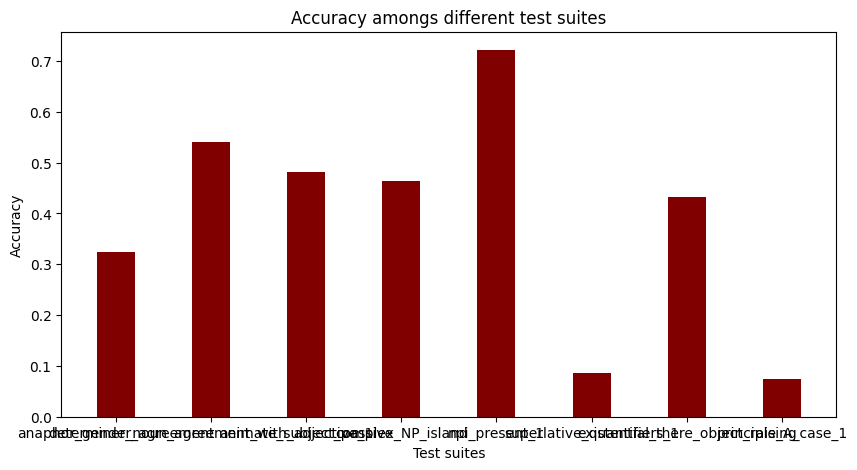

In [95]:
# calculate the performance by test suite
import matplotlib.pyplot as plt 
from statsmodels.stats.proportion import proportion_confint
### YOUR CODE HERE ###
# Calculate performance by test suite
results = {name: cal_accuracy(dataset, lm_scorer) for name, dataset in datasets.items()}

# Calculate performance by category
categories = ['morphology', 'syntax', 'semantics', 'syntax_semantics']
category_results = {category: {'correct': 0, 'total': 0} for category in categories}

for name, (accuracy, correct, total) in results.items():
    category = test_suites[name]
    category_results[category]['correct'] += correct
    category_results[category]['total'] += total

# Calculate accuracy and confidence intervals for each category
category_acc = []
category_ci_lower = []
category_ci_upper = []

for category in categories:
    correct = category_results[category]['correct']
    total = category_results[category]['total']
    accuracy = correct / total
    category_acc.append(accuracy)
    
    # Calculate confidence interval
    ci_l, ci_u = proportion_confint(correct, total, alpha=0.05, method='normal')
    category_ci_lower.append(ci_l)
    category_ci_upper.append(ci_u)

# plot the results in a bar plot
### YOUR CODE HERE ###
test_suite_names = list(results.keys())
test_suite_acc = [acc for acc, _, _ in results.values()]
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(test_suite_names, test_suite_acc, color ='maroon', 
        width = 0.4)

plt.xlabel("Test suites")
plt.ylabel("Accuracy")
plt.title("Accuracy amongs different test suites")
plt.show()

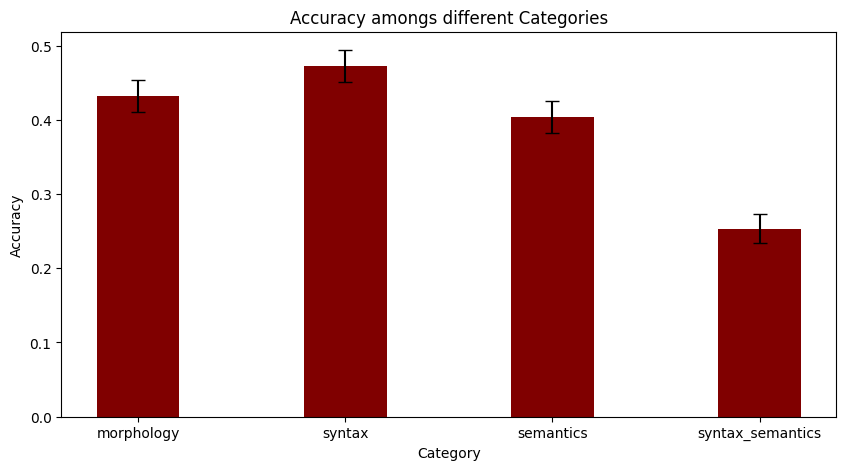

In [97]:
# calculate the performance as described above by category and plot the results in a bar plot with CIs
### YOUR CODE HERE ###

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(categories, category_acc, color ='maroon', 
        width = 0.4, yerr=[np.array(category_acc) - np.array(category_ci_lower), np.array(category_ci_upper) - np.array(category_acc)], capsize=5)

plt.xlabel("Category")
plt.ylabel("Accuracy")
plt.title("Accuracy amongs different Categories")
plt.show()


## Exercise 2: Evaluating societal biases (13 points)

In this exercise, we will consider aspects of LLM performance which may have social implications and that are deeply interconnected with how humans use language. This task evaluates whether LLMs overrepresent certain cultures over others, which could be due to, e.g., imbalances over training data sources and languages.

> Specifically, your task is to come up with an appropriate test item and evaluate whether LLMs exhibit certain cultural biases. 
> In this task, you have to construct your own multiple-choice test item for investigating cultural biases of LLMs, where, given a context, the different available response / continuation options would reflect preferences for responses typical for different cultures. 
> For instance, one response could be more acceptable under one particular cultural lense and another response under a different cultural background. 
> Your task is then to evaluate the performance of two LLMs: the mostly monolingual `gpt2` and the multilingual `bigscience/bloom-550m` model. The second part of the task is to compelte the evaluation code and interpret the results by answering the question below.


Here is a simple example of a test item. More explanations are in parentheses. You should provide analogous explanations in the answers to the questions below, but not pass these to the LLMs during evaluations.


Context 1: You are at a German supermarket. You walk up to the cashier and greet them by saying:

Context 2: You are at an American supermarket. You walk up to the cashier and greet them by saying:

A. Hello. (intuititvely, more likely in to be appropiate in the Germany context condition)

B. Bye. (a generally inappropriate response)

C. Hello, how are you? (intuitively, more likely to be appropriate in the US context condition; people usually don’t ask strangers ‘how are you’ in Germany)

I would say: (insert each of the answer options separately here and calculate their log probability, given each of the contexts).


For reference about constructing datasets and inspiration, feel free to take a look at the [ETHICS dataset](https://arxiv.org/pdf/2008.02275), e.g., Fig. 2, where the authors came up with different continuations tapping into different conditions, given a context.

> **Fill in your responses below.**
>
> 1. Your prompt (with explanations of the intuitive differences for each response option in respective cultural variations):

<br>Context 1:
You are now in Germany. Your friend finds that she is running out of food on Sunday. She asks you to go to the supermarket with her, and you say:

<br>Context 2:
You are now in America. Your friend finds that she is running out of food on Sunday. She asks you to go to the supermarket with her, and you say:

<br>Options:
<br>A. "Most supermarkets are closed on Sunday." (intuititvely, more likely in to be appropiate in the Germany context condition, as supermarkets are typically closed on Sundays in Germany)
<br>B. "I am hungry." (Inappropriate response)
<br>C. "Sure, I can drive you there." intuitively, more likely to be appropriate in the US context condition,as supermarkets are generally open on Sundays)

> 2. Your model log probabilities (table cells are examples, please fill in with your respective item):
>
| Context / Option | GPT-2 | Bloom |
|------------------|-------|-------|
| Germany + A      | -14.025780  | -16.004089 |
| USA + A          | -14.991058  | -16.683868 |
| Germany + B      | -12.836784  | -13.968323 |
| USA + B          | -12.918755  | -14.298187 |
| Germany + C      | -12.453011  | -12.477020 |
| USA + C          | -12.182587  | -12.716522 |


> 3. Do the models show a preference for a particular cultural setting? Is there evidence for whether cultural biases might be caused by training data?
<br> The models do not appear to strongly differentiate between the culturally relevant response for Germany ("Most supermarkets are closed on Sunday.") and the culturally neutral or irrelevant responses. This could suggest that the training data does not include enough examples to strongly learn specific cultural norms.
> 4. Are there aspects of the prompt that might influence your results? Please provide a brief justification / example why (not).
<br>Yes, the wording of the prompt might influence the results. Specifying cultural differences directly in the prompt can guide the models to provide more culturally relevant responses. 
<br>For example:
<br>"In Germany, it is common for supermarkets to be closed on Sundays. You are now in Germany. Your friend finds that she is running out of food on Sunday. She asks you to go to the supermarket with her, and you say:"
<br>"In the USA, it is common for supermarkets to be open every day. You are now in America. Your friend finds that she is running out of food on Sunday. She asks you to go to the supermarket with her, and you say:"

In [4]:
from minicons import scorer 
import pandas as pd

In [64]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cpu')

In [81]:
# here is some starter code; please fill in your code / comments where it says #### YOUR CODE / COMMENT HERE ####

# set up a scorer 
gpt2_scorer = scorer.IncrementalLMScorer(
   'gpt2',  device=device
)

bloom_scorer = scorer.IncrementalLMScorer(
   "bigscience/bloom-560m", device=device
)
# initialize list for storing the predictions
gpt2_predictions = []
bloom_predictions = []

contexts = [
    "You are now in Germany. Your friend finds that she is running out of food on Sunday. She asks you to go to the supermarket with her, and you say:",
 "You are now in America. Your friend finds that she is running out of food on Sunday. She asks you to go to the supermarket with her, and you say:"
]

ger = "Most supermarkets are closed on Sunday. " 
nonsense = "I am hungry." 
us = "Sure, I can drive you there." 
answer_options = ["ger", "nonsense", "us"]

# iterate over contexts
for context in contexts:
    # Create a list with the context repeated for each answer option
    context_list = [context] * len(answer_keys)
    
    # Get conditional scores for GPT-2
    answer_scores_gpt2 = gpt2_scorer.conditional_score(
        # format the question into a list of same length as the number of answer options
        ### YOUR CODE HERE ###,
        context_list, answer_options)
    gpt2_predictions.append(answer_scores_gpt2)
    
    # Get conditional scores for Bloom
    answer_scores_bloom = bloom_scorer.conditional_score(
        # format the question into a list of same length as the number of answer options
        ### YOUR CODE HERE ###,
        context_list, answer_options)
    bloom_predictions.append(answer_scores_bloom)

# check / inspect which answer has the highest score and which answer type (i.e., "culture") it corresponds to
### YOUR CODE / COMMENT HERE ### 

context_labels = ['Germany + A', 'Germany + B', 'Germany + C', 'USA + A', 'USA + B', 'USA + C']
gpt2_flat_predictions = [score for sublist in gpt2_predictions for score in sublist]
bloom_flat_predictions = [score for sublist in bloom_predictions for score in sublist]

df = pd.DataFrame({
    'Context': context_labels,
    'GPT-2': gpt2_flat_predictions,
    'Bloom': bloom_flat_predictions
})

print(df)

       Context      GPT-2      Bloom
0  Germany + A -14.025780 -16.004089
1  Germany + B -12.836784 -13.968323
2  Germany + C -12.453011 -12.477020
3      USA + A -14.991058 -16.683868
4      USA + B -12.918755 -14.298187
5      USA + C -12.182587 -12.716522


## Exercise 3: LLM evaluations with LLMs (5 points)

Building on the in-context learning capabilities of LLMs,, recent work, e.g., by [Perez et al (2022)](https://arxiv.org/abs/2212.09251), has been *using LLMs to generate evaluation datasets for LLMs*. 

> Your task here is to: 
> 1. write a pseudo-algorithm for generating more cultural bias evaluation items. The items should be of a similar structure as in the task above. Write maximally 5 steps. (Hint: feel free to try to elicit e.g. 10 different item with a model of your choice)
> 2. What could be possible concerns with this approach? Name and briefly explain 2.

## Exercise 4: How human-like are Llama's surprisals? (22 points)

More recently, work more informed by human language use and processing has compared LLMs’ performance to aspects of human behavior. Here, the assessment of LLMs is guided more by the question of how human-like certain aspects of its performance are. For instance, we might whether LLMs' 'knowledge' of language is comparable to human knowledge, and, in particular, whether the processing of language, given the knowledge , can be compared via system-appropriate linking measurements.

Your task in this exercise is to assess whether the *surprisal* of different language models is comparable to human *reading times*, when it comes to processing subject-verb agreement. The linking hypothesis is that these can be considered the respective predictability, and therefore, processing load indicators.
The conceptual ideas and the data are taken from [Wilcox et al. (2021)](https://arxiv.org/pdf/2106.03232) which was discussed in the lecture. Please read the sections 1-2.2 for the background (optionally, the rest, if you want).
The data can be downloaded [here](https://github.com/CogSciPrag/Understanding-LLMs-course/tree/main/understanding-llms/homework/data/SVA_data.csv).

The data provides human RTs and LM surprisals in different conditions for sentences where the subject and the verb either match (i.e., agree) or mismatch in terms of number. This is the main condition. Furthermore, the agreement manipulation occurs in different syntactic conditions, and for plural and singular nouns. Here are examples from the different syntactic conditions:
* SRC (subject relative clause modifier):
  * mismatch plural: The pilots that injured the teacher brings love to people.
  * match plural: The pilots that injured the teacher bring love to people.
* ORC (object relative clause modifier):
  * mismatch plural: The ministers that the manager injured knows tennis.
  * match plural: The ministers that the manager injured know tennis.
* PP (prepositional phrase modifier):
  * mismatch plural: The executives next to the teacher is good.
  * match plural: The executives next to the teacher are good.

The prediction is that humans and models should have difficulty processing the mismatched noun, both in the singular and the plural condition.

> Your task is to complete / provide the following code and answer the following questions:
> 1. Formulate a quantitatively testable hypothesis operationalizing the prediction above. I.e., formulate something like: if the prediction is true, X should be larger than Y.
> 2. Provide respective examples for the singular condition.
> 3. Inspect the data. What are the units of the provided results?
> 4. Based on your hypothesis above, for each trial, calculate whether it holds or not. Plot the proportion of trials where your hypothesis is borne out (i.e, the accuracy), for humans and each model, in the singular and the plural condition. (Hint: use a barplot)
> 5. Based on visual inspection, does any model match human performance

None of the models exaclty match human performance. 

> 6. Is either of the number conditions more difficult to process for humans or LMs?

Humans find singular conditions more difficult, while LMs generally find plural conditions more challenging.

> 7. Select the results for Llama and humans only. Is the processing 'difficulty' of Llama correlated with the processing slowdown of humans (across singular / plural conditions)? Interpret the correlation coefficient.

Correlation between Llama and human processing difficulties is weak and not statistically significant

**Task 1:** The prediction is that humans and models should have difficulty processing the mismatched noun, both in the singular and the plural condition.
<br>If the prediction is true, longer reading times for mismatched sentences compared to matched sentences for humans and higher surprisal values for mismatched sentences compared to matched sentences for LLMs.
> In a clearer representation:
><br>For humans: ReadingTime(mismatch) > ReadingTime(match)
><br>For LLMs: Surprisal(mismatch) > Surprisal(match)

**Task 2:** Provide respective examples for the singular condition.

>SRC:
><br>Mismatch singular: "The pilot that injured the teacher bring love to people."
><br>Match singular: "The pilot that injured the teacher brings love to people."
><br>ORC:
><br>Mismatch singular: "The minister that the manager injured know tennis."
>Match singular: "The minister that the manager injured knows tennis."
><br>PP:
><br>Mismatch singular: "The executive next to the teacher are good."
><br>Match singular: "The executive next to the teacher is good."

**Task 3:** The units of the provided results are surprisal values for models and reading times for humans.

In [113]:
df = pd.read_csv("C:/Users/Jessi/Desktop/Tuebingen_sem_3/SVA_data.csv")
df.head()
#df['model'].drop_duplicates()

,suite,region_number,group,model,match_plural,match_sing,mismatch_plural,mismatch_sing
0,SVNA-orc,7,1010,gpt2,7.740553,7.936675,11.336713,8.637131
1,SVNA-orc,7,1010,grnn,5.123765,4.921309,5.999019,7.279292
2,SVNA-orc,7,1010,human,633.333333,914.000000,733.000000,1012.125000
3,SVNA-orc,7,1010,jrnn,4.376238,4.826594,6.055298,6.815393
4,SVNA-orc,7,1010,llama,5.940623,5.992930,10.196010,10.679944


In [103]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [134]:
#### YOUR CODE HERE FOR CALCULATING HYPOTHESIS METRICS AND PLOTTING ####
# Define columns for whether the hypothesis holds
import numpy as np
df_human = df.loc[df['model'] == 'human'].dropna()
df_gpt2 = df.loc[df['model'] == 'gpt2'].dropna()
df_grnn = df.loc[df['model'] == 'grnn'].dropna()
df_jrnn = df.loc[df['model'] == 'jrnn'].dropna()
df_llama = df.loc[df['model'] == 'llama'].dropna()
df_rnng = df.loc[df['model'] == 'rnng'].dropna()


def acc_cal(model):
    """
    Calculate accuracy lists for plural and singular mismatches.

    Parameters:
    model (pd.DataFrame): DataFrame containing 'mismatch_plural', 'match_plural',
                          'mismatch_sing', and 'match_sing' columns.

    Returns:
    accuracy of plural and singular
    """
    acc_pl = []
    acc_sg = []

    for index, row in model.iterrows():
        # Calculate accuracy for plural
        if row['mismatch_plural'] > row['match_plural']:
            acc_pl.append(1)
        else: 
            acc_pl.append(0)
        
        # Calculate accuracy for singular
        if row['mismatch_sing'] > row['match_sing']:
            acc_sg.append(1)
        else: 
            acc_sg.append(0)
            
    accuracy_pl = np.mean(acc_pl)
    accuracy_sg = np.mean(acc_sg)
    return accuracy_sg, accuracy_pl, acc_sg, acc_pl 
            
    

human_accuracy_singular, human_accuracy_plural, human_sglist, human_pllist = acc_cal(df_human)
gpt2_accuracy_singular, gpt2_accuracy_plural, _, _ = acc_cal(df_gpt2)
grnn_accuracy_singular, grnn_accuracy_plural, _, _ = acc_cal(df_grnn)
jrnn_accuracy_singular, jrnn_accuracy_plural, _, _ = acc_cal(df_jrnn)
llama_accuracy_singular, llama_accuracy_plural, llama_sglist, llama_pllist = acc_cal(df_llama)
rnng_accuracy_singular, rnng_accuracy_plural,  _, _ = acc_cal(df_rnng)


# Prepare data for plotting
accuracy_data = {
    'Model': ['Human_Sg', 'Human_Pl', 
              'GPT2_Sg', 'GPT2_Pl', 
              'GRNN_Sg', 'GRNN_Pl', 
              'JRNN_Sg', 'JRNN_Pl',  
              'Llama_Sg', 'Llama_Pl',
              'RNNG_Sg', 'RNNG_Pl'],
    'Accuracy': [human_accuracy_singular, human_accuracy_plural, 
                 gpt2_accuracy_singular, gpt2_accuracy_plural,
                 grnn_accuracy_singular, grnn_accuracy_plural, 
                 jrnn_accuracy_singular, jrnn_accuracy_plural,
                 llama_accuracy_singular, llama_accuracy_plural,
                rnng_accuracy_singular, rnng_accuracy_plural]
}

accuracy_df = pd.DataFrame(accuracy_data)
accuracy_df

,Model,Accuracy
0,Human_Sg,0.875
1,Human_Pl,0.575
2,GPT2_Sg,0.775
3,GPT2_Pl,0.925
4,GRNN_Sg,0.625
5,GRNN_Pl,0.825
6,JRNN_Sg,0.700
7,JRNN_Pl,0.800
8,Llama_Sg,0.850
9,Llama_Pl,0.925


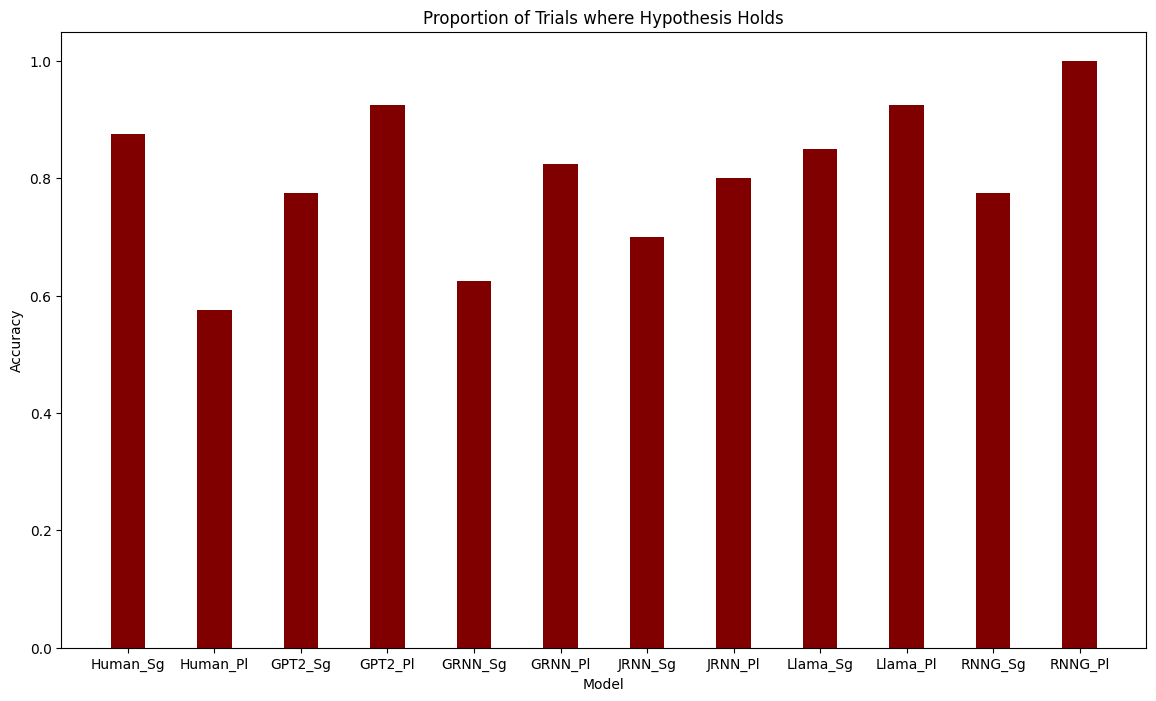

In [135]:
# barplot of the results, by model and by condition (plural vs. singular)
### YOUR CODE HERE ###

# Plot the results
plt.figure(figsize=(14, 8))
plt.bar(accuracy_data['Model'], accuracy_data['Accuracy'], color ='maroon', 
        width = 0.4)
plt.title('Proportion of Trials where Hypothesis Holds')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()


In [129]:
# correlation analysis
#### YOUR CODE HERE ##

singular_corr = pearsonr(human_sglist, llama_sglist)
plural_corr = pearsonr(human_pllist, llama_pllist )

singular_corr, plural_corr

(PearsonRResult(statistic=0.05292561240249635, pvalue=0.7456775488245947),
 PearsonRResult(statistic=0.13920285090358006, pvalue=0.3916324316834421))